In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import networkx as nx
import nxpd as nxpd
import community as comm
import GraphTools as gt
from collections import deque
from itertools import product

plt.style.use('ggplot')

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Install Instructions

You may need to install the following modules and utilities to get this notebook to run

* `brew install graphviz` (Mac) or `sudo apt-get graphviz` (Linux)
* `pip install python-louvain`
* `pip install nxpd`

Graphs and Networks - Morning Lecture
========================

A graph is a mathematical data structure consisting of **nodes/vertices** and **edges**.

### A social graph from facebook:

![Facebook Social Graph](fb-social-graph.jpg)

**Vertices** are facebook profiles.

**Edges** are social connections.

### Computer Connection Across the Internet:

![The Internet](internet.png)

**Vertices** are computers.

**Edges** are direct connections from one computer to another.

### The London Tube:

![London Tube Map](tube-map.gif)

**Vertices** are tube (subway) stations.

**Edges** are subway connections.

Graphs are mathematical abstractions, the pictures are only there to help our brains comprehend the data.

The **actual** London subway's geographic structure look like this:

![Geographically Accurate Tube Map](tube-map-actual.jpg)

The original graph is the **Seven Bridges of Königsberg**:

![Bridges of Konigsberg](bridges.png)

**Discussion:** Is it possible to walk around the city, crossing every bridge, but each *exactly* once?

Formally, a graph is

  - A set $V$ of **vertices**.  Vertices are abstract entities, can represent pretty much anything, and can have data attached.
  - A set $E$ of **edges**, which are ordered or un-ordered pairs of vertices.

So, for example:

$$ V = \{1, 2, 3, 4, 5, 6 \} $$
$$ E = \left\{ \{1, 2\}, \{1, 5\}, \{2, 3 \}, \{2, 4\}, \{3, 4\}, \{3, 6\}, \{4, 5\}, \{5\} \right\} $$

This does not tend to be a very efficient or useful representation though.

**Question:** What is the $\{ 5 \}$ communicating in the edge set?

**Discussion:** How would we approach detecting insurance fraud using a graph data structure?

### Neighbourhood Graphs

If we take a scatterplot and join up any pair of points that are within some closeness of one another, we get a *neighbourhood graph*.

(0, 1)

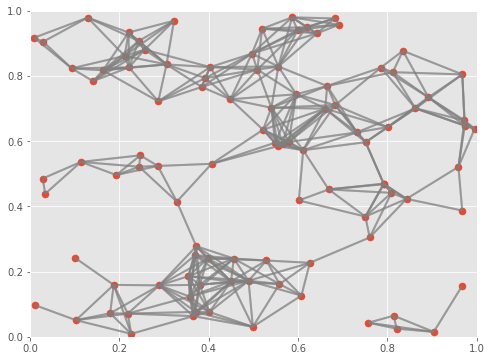

In [2]:
x = np.random.uniform(size=100)
y = np.random.uniform(size=100)

fix, ax = plt.subplots(1, figsize=(8, 6))

line_segments = []
for ((x_1, y_1), (x_2, y_2)) in product(zip(x, y), zip(x, y)):
    if (x_1 - x_2)**2 + (y_1 - y_2)**2 <= 0.025:
         line_segments.append(((x_1, y_1), (x_2, y_2)))
            
lc = mc.LineCollection(line_segments, color="grey", alpha=0.5, 
                       linewidths=2)
ax.add_collection(lc)

ax.scatter(x, y, s=50)
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))

These graphs underlie many important clustering algorithms.

# Data Structures for Graphs

There are two main data structures used for representing a graph.

  - The **Adjacency list** representation lists the vertices, and then the vertices lined to *that* vertex with an edge.
  - The **Adjacency matrix** representation creates a square matrix with rows and columns indexed by the vertices.  The entries in the matrix are either $0$ or $1$, depending on whether the vertices are linked with an edge.

The *adjacency list* representation of a graph could be:

In [3]:
g_adj = {
    0: {1, 4},
    1: {0, 2, 3},
    2: {1, 3, 5},
    3: {1, 2, 4},
    4: {0, 3, 4},
    5: {2}
}

**Exercise**: Draw the graph this data structure represents.

The *adjacency matrix* representation of the graph is

In [4]:
g_matrix = np.array([
    [0, 1, 0, 0, 1, 0],
    [1, 0, 1, 1, 0, 0],
    [0, 1, 0, 1, 0, 1],
    [0, 1, 1, 0, 1, 0],
    [1, 0, 0, 1, 1, 0],
    [0, 0, 1, 0, 0, 0]
])

**Discussion:** If $G$ is the *adjacency matrix* of a graph, what graph does $G^2$ represent?

The python library's `networkx` and `nxpd` can be used to manipulate and visualize graphs.

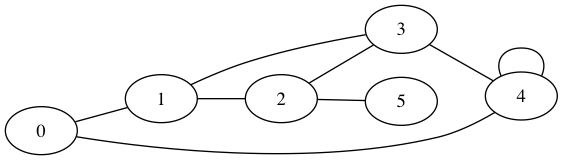

In [5]:
G = nx.from_dict_of_lists(g_adj)
# Draw left to right when possible, fits better in notebook
G.graph['rankdir'] = 'LR'
nxpd.draw(G, show='ipynb')

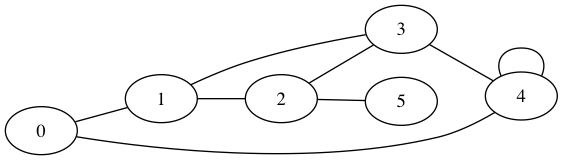

In [6]:
G = nx.Graph(g_matrix)
G.graph['rankdir'] = 'LR'
nxpd.draw(G, show='ipynb')

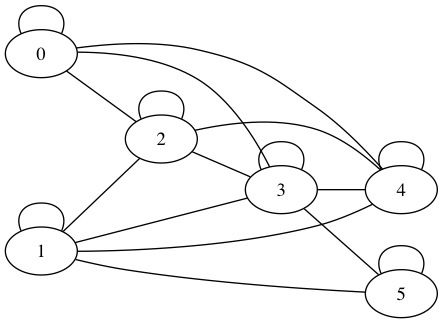

In [7]:
G2 = nx.Graph(np.dot(g_matrix, g_matrix))
G2.graph['rankdir'] = 'LR'
nxpd.draw(G2, show='ipynb')

In [8]:
print(np.dot(g_matrix, g_matrix))

[[2 0 1 2 1 0]
 [0 3 1 1 2 1]
 [1 1 3 1 1 0]
 [2 1 1 3 1 1]
 [1 2 1 1 3 0]
 [0 1 0 1 0 1]]


**Exercise:** Write a function to convert an *adjacency list* to an *adjacency matrix*.

In [9]:
# Solution goes here.

In [10]:
gt.adjacency_list_to_matrix(g_adj)

array([[ 0.,  1.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  1.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.,  1.],
       [ 0.,  1.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.]])

## Basic Graph Concepts

The **neighbors** of a vertex are all those connected to it by an edge.

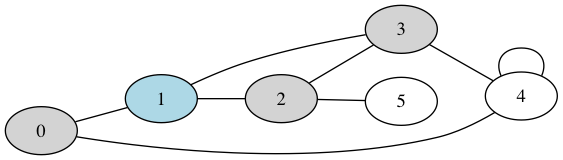

In [11]:
gt.color_nodes(G, [1], 'lightblue')
gt.color_nodes(G, G.neighbors(1), 'lightgrey')
nxpd.draw(G, show='ipynb')

The **degree** of a vertex is the number of edge ends incedent on it.
$$ d(0) = 2 $$
$$ d(1) = 3 $$
$$ d(4) = 4 $$

A **path** is a series of edges that connect up at vertices.

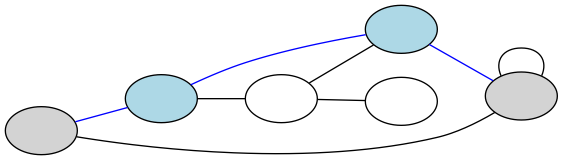

In [12]:
gt.reset_graph(G)
gt.color_nodes(G, [0, 4], 'lightgrey')
gt.color_nodes(G, [1, 3], 'lightblue')
gt.color_edges(G, [(0, 1), (1, 3), (3, 4)], 'blue')
nxpd.draw(G, show='ipynb')

A graph is **Connected** if every pair of vertices is connected by some path.

A graph is **Disconnected** if it is not connected.  In this case, each connected piece of the graph is called a **component**.

**Exercise:** Fill in the adjacency list for a *disconnected* graph, then plot it.

In [13]:
g_disconnected = {
    # Fill in this.
}

G_disconnected = nx.from_dict_of_lists(g_disconnected)
nxpd.draw(G_disconnected, show='ipynb')

A **cycle** in a graph is a sequence of edges that returns to the same vertex from which it began:

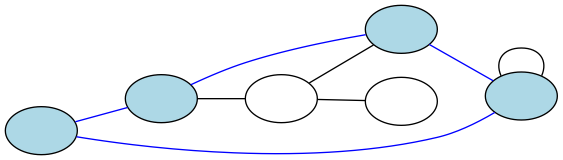

In [14]:
gt.reset_graph(G)
gt.color_nodes(G, [0, 1, 3, 4], 'lightblue')
gt.color_edges(G, [(0, 1), (1, 3), (3, 4), (4, 0)], 'blue')
nxpd.draw(G, show='ipynb')

## Types of Graphs


The graphs we have been discussing so far have been **undirected**, where the edges have no associated direction.

In a **directed** graph, each edge has an associated direction, which we represent with arrows.

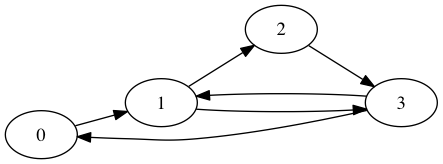

In [15]:
G_dir = nx.DiGraph()
G_dir.add_cycle(range(4))
G_dir.add_edge(1, 3)
G_dir.add_edge(3, 1)
G_dir.graph['rankdir'] = 'LR'
nxpd.draw(G_dir, show='ipynb')

The graphs we have been discussing so far have all been **unweighted**.

In a **weighted** graph, all the edges have some associated numbers, the weights.

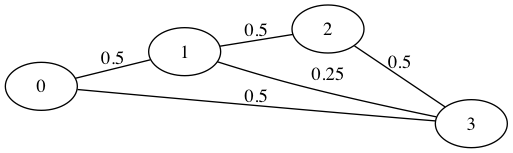

In [16]:
G_weight = nx.Graph()
G_weight.add_cycle(range(4), weight=0.5)
G_weight.add_edge(1, 3, weight=0.25)
gt.label_edges_with_weights(G_weight)
G_weight.graph['rankdir'] = 'LR'
nxpd.draw(G_weight, show='ipynb')

The weights could represent
  - Carrying capacity of a road, pipe, etc.
  - Resistance in a wire.
  - Network traffic across a connection.
  - Strength of an atomic bond.
  
Etc.

A **tree** is a un-directed graph with no cycles.

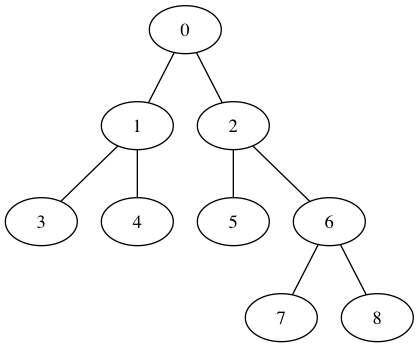

In [17]:
g_tree = {
    0: {1, 2},
    1: {3, 4},
    2: {5, 6},
    3: {},
    4: {},
    5: {},
    6: {7, 8},
    7: {},
    8: {}
}

G_tree = nx.from_dict_of_lists(g_tree)
nxpd.draw(G_tree, show='ipynb')

Trees are perhaps the most important types of graphs.  They are used as fundamental data structures in computer science:
  - Hash tables.
  - Data bases.
  - Sorting Algorithms.

## Search Algorithms - Breadth First Search

A **search algorithm** is a method for visiting every node in a graph.  This is very important for many applications of graphs:

  - Finding shortest paths from one place to another.  Think of optimizing shipping routes.
  - Looking up data in complex data structures.  This is how tables in very optimized databases work.

In **[breadth first search](https://en.wikipedia.org/wiki/Breadth-first_search)** we traverse the graph, prioritizing visiting all the *neighbours* of nodes before visiting *more neighbours*.

**Intermission:** Review data structures.  **Stack** and **Queue**.

Preudocode.

    Create an empty queue Q.
    Initialize an empty set *V* of visited nodes.
    Add starting vertex to *Q*.
    
    While Q is not empty:
        Pop (earliest added) vertex from Q, call it v.
        if v is not already visited.
            Add v to V (the visited set).
            Add every neighbour of v to (the end of) Q.

Real code.

In [18]:
def breadth_first_search(G, initial_node, do=(lambda v: None)):
    Q = deque()
    # Using a list so I can preserve to order I visited nodes.
    visited = []
    Q.append(initial_node)
    while len(Q) != 0:
        v = Q.popleft()
        if v not in visited:
            visited.append(v)
            Q.extend(G.neighbors(v))
    return visited

We can label nodes by the search order to visualize the algorithm.

In each of these pictures the *blue* node is visited first.

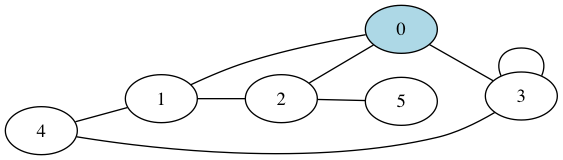

In [19]:
search_order = {v: i for i, v in 
                enumerate(breadth_first_search(G, 3))}
gt.reset_graph(G)
gt.color_nodes(G, [3], 'lightblue')
gt.label_nodes(G, search_order)
nxpd.draw(G, show='ipynb')

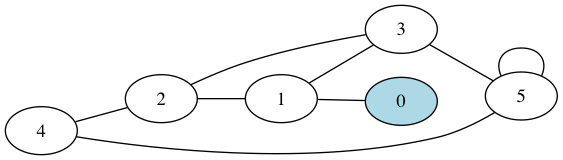

In [20]:
search_order = {v: i for i, v in 
                enumerate(breadth_first_search(G, 5))}
gt.reset_graph(G)
gt.color_nodes(G, [5], 'lightblue')
gt.label_nodes(G, search_order)
nxpd.draw(G, show='ipynb')

**Question:** What information does the *order nodes are visited* in the breadth first search algorithm contain?

The sprint for today uses the ideas in this algorithm to compute the shortest path between two nodes.

## Afternoon - Centrality Measures and Communities

Often it is important for us to measure the *importance* of a node in a graph.  There are **many** applications for different versions of this idea.

  - Fraud rings in insurance claims.
  - Influencers.
  - Bottlenecks for network traffic.
  - Page Rank.

### Degree Centrality

The **degree centrality** measure of a vertex in a graph is defined by:

$$ \text{degree_centrality}(v) = \frac{\text{degree}(v)}{\text{number of vertices in } G}$$

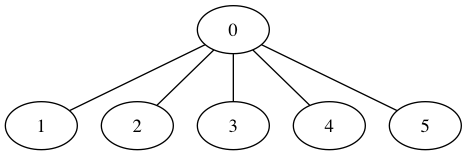

In [21]:
g_star = {
    0: {1, 2, 3, 4, 5},
    1: {0},
    2: {0},
    3: {0},
    4: {0},
    5: {0}
}

G_star = nx.from_dict_of_lists(g_star)
nxpd.draw(G_star, show='ipynb')

**Exercise:** Compute the degree centrality of the vertices in this graph.

*Hint*:  You should only have to compute the centrality of *two* vertices explicitly.

### Betweenness Centrality

While the *degree centrality* is easy to calculate, it often misses important features of a graph we would intuitively recognise as important.

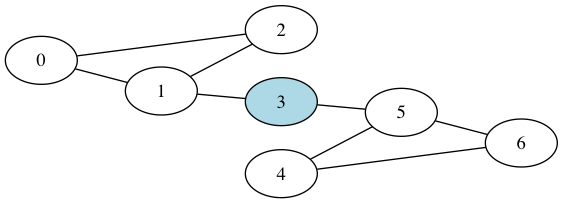

In [22]:
g_triangle = {
    0: {1, 2},
    1: {0, 2},
    2: {0, 1},
    3: {1, 5},
    4: {5, 6},
    5: {4, 6},
    6: {4, 5},
}

G_triangle = nx.from_dict_of_lists(g_triangle)
G_triangle.graph['rankdir'] = 'LR'
gt.color_nodes(G_triangle, [3], 'lightblue')
nxpd.draw(G_triangle, show='ipynb')

**Exercise:** What is the degree centrality of the highlighted node?

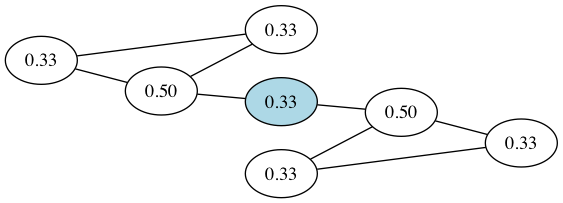

In [23]:
degree_centralities = gt.format_dict_of_floats(nx.degree_centrality(G_triangle))
gt.label_nodes(G_triangle, degree_centralities)
nxpd.draw(G_triangle, show='ipynb')

The breadth first search algorithm can be used to efficiently calculate the number of the number of shortest paths through a given vertex.

$$ \sigma_{uv} = \text{# of shortest paths between u and v} $$
$$ \sigma_{uv}(w) = \text{# of shortest paths between u and v that pass through w} $$

The *betweenness centrality* of a vertex measures how often we need to pass through the vertex to move around the graph

$$ \text{betweenness_centrality}(w) = \sum_{u \neq w, v \neq w} \frac{ \sigma_{uv}(w) }{ \sigma_{uv} } $$

The *normalized betweenness centrality* is

$$ \frac{ \text{betweenness_centrality}(w) }{ \frac{(n-1)(n-2)}{2} } $$

**Question:** Whats with the denominator?

**Activity:** Compute the betweenness centrality of all the nodes in the two triangle graph.

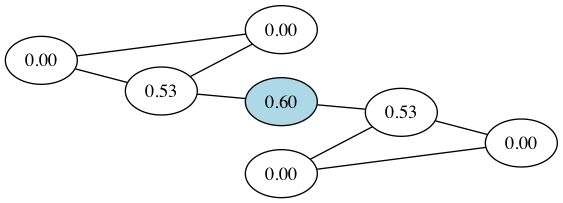

In [24]:
between_centralities = gt.format_dict_of_floats(nx.betweenness_centrality(G_triangle))
gt.label_nodes(G_triangle, between_centralities)
nxpd.draw(G_triangle, show='ipynb')

We will also see later that the concept of betweenness centrality can also be applies to edges in the graph, resulting in cool pictures like this:

![Roads Betweeness Centrality](edge-betweeness.png)

### Eigenvector Centrality

Suppose we try to invent a centrality measure that satisfies the following appealing property

> The centrality of a vertex $v$ is always equal to the sum of the centralities of it's neighbours.

If $A$ is the adjacency matrix of a graph, and $x$ is the vector containing our postulated centrality measures, we can be express this idea as system of linear equations

$$ x_i = \sum_j A_{ij} x_j $$

or, as the single matrix equation

$$ x = A x $$

This matrix equation may *not* have solutions, but the similar eigenvector equation does

$$ Ax = \lambda x $$

**Question:** Does $A$ actually have any eigenvectors / eigenvalues?

If we take $\lambda_{max}$, the *largest* eigenvalue of $A$, then the solution vector $x$ *defines* the **eigenvector centrality** of our graph

$$ A x_{\text{eigenvector centrality}} = \lambda_{\text{max}} x_{\text{eigenvector centrality}} $$

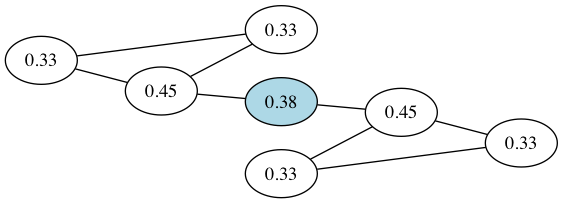

In [25]:
eigen_centralities = gt.format_dict_of_floats(nx.eigenvector_centrality(G_triangle))
gt.label_nodes(G_triangle, eigen_centralities)
nxpd.draw(G_triangle, show='ipynb')

Here's a picture from wikipedia that shows the concept a bit more clearly.

![Eigenvector Centrality](eigenvector-centrality.png)

**Note:** Eigenvector centrality was a fundamental component of early versions of *page rank*, Google's web page ranking algorithm.

**Discussion:** How should we interpret $\lambda$, the eigen*value* in the definition?

## Communities

Recall the idea of *clusters* in data sets

In [26]:
def make_two_clusters(size, d):
    """Make two gaussian clusters.  d is the distance between the cluster centers."""
    x = np.concatenate([np.random.normal(loc=-d/2, size=size), 
                        np.random.normal(loc=d/2, size=size)])
    y = np.concatenate([np.random.normal(loc=0, size=size),
                        np.random.normal(loc=0, size=size)])
    return x, y

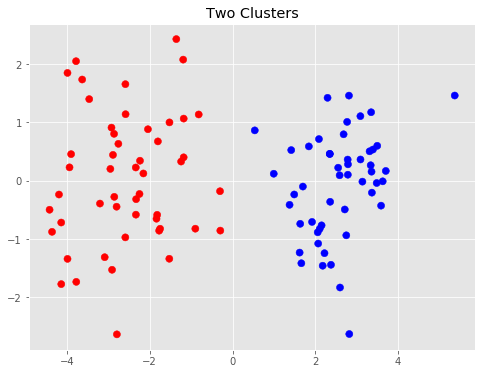

In [27]:
x, y = make_two_clusters(50, 5.0)

fix, ax = plt.subplots(1, figsize=(8, 6))
_ = ax.scatter(x, y, s=50, color=(["red"]*50 + ["blue"]*50))
_ = ax.set_title("Two Clusters")

The idea in clustering was that:

> Pairs of points in the *same* cluster are closer than pairs of points in *different* clusters.

In [28]:
def make_segments_in_nbhd_graph(x, y, D):
    line_segments = []
    for ((x_1, y_1), (x_2, y_2)) in product(zip(x, y), zip(x, y)):
        if (x_1 - x_2)**2 + (y_1 - y_2)**2 <= D:
             line_segments.append(((x_1, y_1), (x_2, y_2)))
    lc = mc.LineCollection(line_segments, color="grey", alpha=0.2, 
               linewidths=2)
    return lc

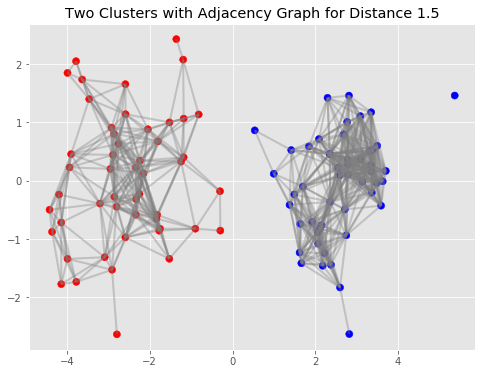

In [29]:
D = 1.5

fix, ax = plt.subplots(1, figsize=(8, 6))

lc = make_segments_in_nbhd_graph(x, y, 1.5)
ax.add_collection(lc)

_ = ax.scatter(x, y, s=50, color=(["red"]*50 + ["blue"]*50))
_ = ax.set_title("Two Clusters with Adjacency Graph for Distance {}".format(D))

Remember that in the *adjacency graph* we connect two points if they are closer than some prescribed distance.

We can think of clustering in terms of the adjacency graph:

> Points in the *same* cluster are more likely to have an edge between them than points in *different* clusters.

This general concept makes sense for *any* graph, we call the resulting entities **communities**.

![Simple Communities](communities.jpg)

Formally a **community** is a subset of the vertices in a graph.  We say a graph is *partitioned into communities* if

  - Each vertex is in at least one community.
  - Every vertex is in at most one community.
  
We would like to create communities so that the following vague idea is true

> Points in the *same* community are more likely to have an edge between them than points in *different* communities.

Just like in clustering, we need a way to *measure* how true this is for a given partition.

### Modularity

The "goodness" of a partition into communities is measured by *modularity*, which is a somewhat tricky concept.

In [30]:
def make_nbhd_graph(x, y, D):
    G = nx.Graph()
    G.add_nodes_from(zip(x, y))
    for ((x_1, y_1), (x_2, y_2)) in product(zip(x, y), zip(x, y)):
        if (x_1 - x_2)**2 + (y_1 - y_2)**2 <= D:
            G.add_edge((x_1, y_1), (x_2, y_2))    
    return G

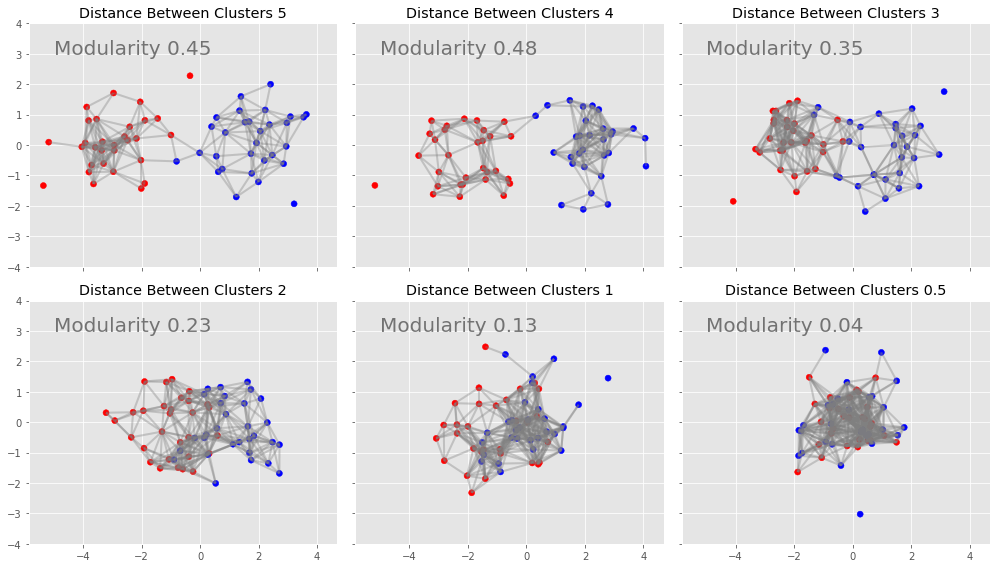

In [33]:
ds = [5, 4, 3, 2, 1, 0.5]

fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)

for d, ax in zip(ds, axs.flatten()):
    x, y = make_two_clusters(30, d)
    ax.scatter(x, y, color=(["red"]*30 + ["blue"]*30))
    ax.set_title("Distance Between Clusters {}".format(d))
    
    lc = make_segments_in_nbhd_graph(x, y, 1.5)
    ax.add_collection(lc)
    
    G = make_nbhd_graph(x, y, d)
    communities = {(x[i], y[i]): i < 30 for i in range(30*2)}
    modularity = comm.modularity(communities, G)
    ax.text(-5, 3, "Modularity {0:2.2f}".format(modularity),
       fontsize=20, alpha=0.5)
    ax.set_ylim(-6, 6)
    ax.set_ylim(-4, 4)
        
plt.tight_layout()

The *idea* of modularity is to compare the graph we have, to what we would expect if we erased the actual edges and drew *random* edges in their place.

Imagine taking a graph and removing the middle of each edge. You'd end up with a bunch of nodes with edge stubs sticking out. If $m$ is the original number of edges, we now have $2m$ stubs. Each node $i$ has $d(i)$ stubs coming out, where $d(i)$ is the degree of node $i$

![](edge_stubs.png)

Now randomly connect the stubs together. We can calculate the probability that node $i$ gets connected to node $j$

$$
\begin{align}
\text{P}(\text{single edge stub gets connected to }j) & = \frac{d(j)}{2m} \\
\text{Expected number of edges from }i\text{ to }j & = \frac{d(i)d(j)}{2m} \\
\text{Expected number of edges between nodes within one community} & = \sum_{i,j \in C} \frac{d(i)d(j)}{2m}
\end{align}
$$

The **modularity** of a partitioning of a graph $G$ into a set of communities $\mathcal{C}$ is defined as the *true* number of edges within communities minus the *expected* number of edges under this random edge assignment (all divided by $2m$)

$$
\text{modularity}(G,\mathcal{C}) = \frac{1}{2m}\sum_{C\in\mathcal{C}}\left[\sum_{i,j\in C}\left(A_{ij} - \frac{d(i)d(j)}{2m}\right)\right]
$$

Where $A_{ij}$ is the entry in the adjacency matrix: $1$ if nodes $i$ and $j$ are connected, $0$ if not.

Modularity (also called [Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_Modularity)) can range from -1 to 1

### Creating Communities

Now that we can measure how good a breakdown into communities is (using modularity) we need an algorithm to create communities for us.

**Inspiration:** If our graph breaks up into *disconnected* pieces, these are certainly good communities.
    
**Idea:** Remove the *minimal* number of edges needed to break the graph into disconnected pieces.  The resulting pieces should be good communities.

Here we can remove the grey edges, and the resulting communities are all colored.

![Simple Communities](communities.jpg)

How can we identify the grey edges if

  - The graph was not drawn so suggestively.
  - Nothing was colored.

**Discussion:** Brainstorm.  How should we identify the edges to remove?

### Betweenness Centrality Redux

Earlier, we defined the **betweenness centrality** measure of a *vertex* as the number of shortest paths that must pass through that vertex.

This idea could equally well apply to *edges*!

![Roads Betweeness Centrality](edge-betweeness.png)

The **betweenness centrality** of an edge $e$ is

$$ \text{betweenness_centrality}(e) = \sum_{u \neq v} \frac{ \sigma_{uv}(e) }{ \sigma_{uv} } $$

Where the $\sigma$s have the same meaning as before:

$$ \sigma_{uv} = \text{# of shortest paths between u and v} $$
$$ \sigma_{uv}(w) = \text{# of shortest paths between u and v that pass through e} $$

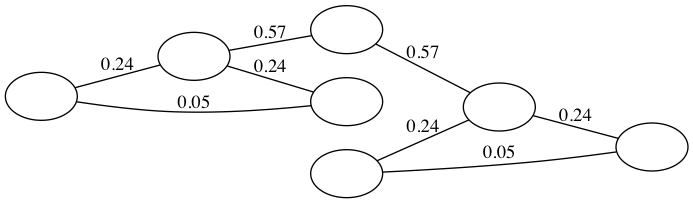

In [32]:
between_centralities = gt.format_dict_of_floats(nx.edge_betweenness_centrality(G_triangle))
gt.reset_graph(G_triangle)
gt.label_edges(G_triangle, between_centralities)
nxpd.draw(G_triangle, show='ipynb')

### Girvan-Newman Algorithm

The **Girvan-Newman** algorithm is a simple way to break a graph down into communities. It procedes by removing edges with the *maximal* centrality.

    Repeat until satisfied:
        Repeat until a new connected component is created:
            Compute the edge betweenness centrality of the current graph.
            Remove the edge with highest betweenness centrality.
    Return the connected components of resulting graph as communities.